In [ ]:
#pip install openpyxl --upgrade

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import gc
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

In [ ]:
seed = 42

In [ ]:
# Calculate RDKit descriptors
descr = Descriptors._descList[0:2] + Descriptors._descList[3:]
calc = [x[1] for x in descr]

In [ ]:
def fingerprint(smiles):
        i=0
        fps_list = []
        chunksize = smiles.shape[0] // 3

        #for chunk in np.split(df, chunksize):
        for chunk in np.array_split(smiles, chunksize):
            #y = chunk['PUBCHEM_ACTIVITY_OUTCOME']
            mols = [Chem.MolFromSmiles(s) for s in chunk]
            del chunk
            fps = np.array(describe(mols))

            fps_list.append(fps)

        fps_train = np.concatenate(fps_list, axis=0)
        return fps_train

In [ ]:
def describe(mols):
    descrs = []
    for mol in mols:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
        fp_list = [int(x) for x in fp.ToBitString()]

        ds_n = [float(np.finfo(np.float32).max if v(mol) > np.finfo(np.float32).max else np.float32(v(mol))) for v in calc]
        descrs.append(fp_list + ds_n)

    return descrs

In [ ]:
train = pd.read_csv('train_data.txt', sep='\t')
train = train.rename(columns={'Smiles String': 'Smiles', 'agg' : 'label'})

test_agg = pd.read_csv('agg_data_test.txt', sep='\t')
test_agg['label']='AGG'
test_agg.drop('ID', axis=1, inplace = True)

test_non_agg= pd.read_csv('nonagg_data_test.txt', sep='\t')
test_non_agg['label']='NONAGG'
test_non_agg.drop('ID', axis=1, inplace = True)

data = pd.concat([test_agg, test_non_agg, train], ignore_index=True)

data = data.rename(columns={'label': 'labels','Smiles' : 'smiles' })

label_map = {
    'AGG': 1,
    'NONAGG': 0,
}

data = data.drop('Unnamed: 0', axis=1 )
data['labels'] = data['labels'].map(label_map)
data.dropna(inplace=True)

In [ ]:
data.head(2)

,smiles,labels
0,C/C(=N/NC(=O)NC1=CCCC=C1)c1cccc(-c2ccccc2)c1,1
1,CC(C)CN(CC(C)C)CP(=S)(CN(CC(C)C)CC(C)C)CN(CC(C...,1


In [ ]:
train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

<AxesSubplot:>

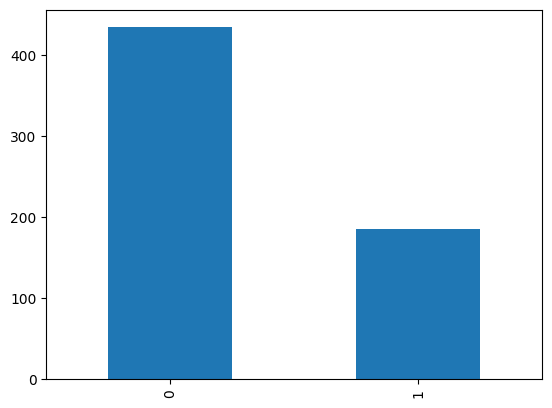

In [ ]:
train_df1['labels'].value_counts().plot.bar()

In [ ]:
smiles = train_df1['smiles']
y = train_df1['labels']#.reset_index()

In [ ]:
fps_train = fingerprint(smiles)

In [ ]:
x = fps_train
# Scale data
scaler = MinMaxScaler()
scaler2 = MinMaxScaler().fit(x)
x = scaler2.transform(x)

nan = np.where(np.asanyarray(np.isnan(x)))
nan_id = nan[0]
nan_id_unique = np.unique(nan_id)
nan_list = nan_id_unique.tolist()
y = y.drop(nan_list, axis = 0)

x = pd.DataFrame(x)
x = x.dropna()

In [ ]:
MLP = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 1000, 1000), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1234, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

model = MLP.fit(x, y)

/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Test evaluation

In [ ]:
smiles = test_df1['smiles']
y = test_df1['labels'].reset_index()

In [ ]:
fps_test = fingerprint(smiles)

In [ ]:
scaler = MinMaxScaler()
x = scaler2.transform(fps_test)
x = pd.DataFrame(x)

nan = np.where(np.asanyarray(np.isnan(x)))
nan_id = nan[0]
nan_id_unique = np.unique(nan_id)
nan_list = nan_id_unique.tolist()

y = y.drop(nan_list)
y = y.drop('index', axis = 1)
x = x.dropna()

In [ ]:
preds = model.predict(x)
probs = model.predict_proba(x)[:, 1]

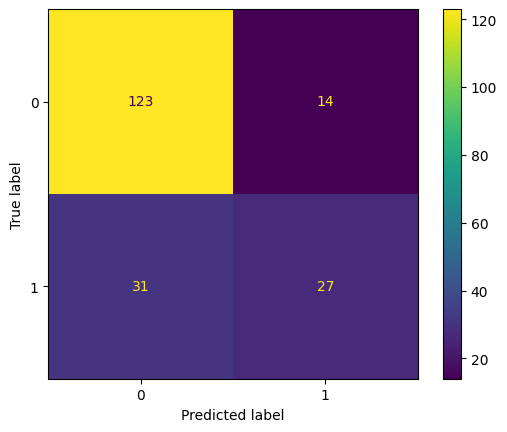

In [ ]:
cm = confusion_matrix(y, preds)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn)) if (tn + fn) > 0 else 0

print('sen:{}'.format(sensitivity))
print('spe:{}'.format(specificity))
print('CCR:{}'.format(ccr))
print('ppv:{}'.format(ppv))
print('nen:{}'.format(npv))

sen:0.46551724137931033
spe:0.8978102189781022
CCR:0.6816637301787063
ppv:0.6585365853658537
nen:0.7987012987012987


In [ ]:
# Calculate the AUC score
auc_score = roc_auc_score(y, probs)

print("AUC-ROC Score:", auc_score)

AUC-ROC Score: 0.7753586710294488


## Ten runs:

In [ ]:
def runs(random_seed_list, data):

  ccr_list = []
  sen_list = []
  spe_list = []
  ppv_list = []
  npv_list = []
  auc_list = []

  for seed in random_seed_list:

        train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
        train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

        train_df1 = train_df1.reset_index(drop=True)
        valid_df1 = valid_df1.reset_index(drop=True)
        test_df1 = test_df1.reset_index(drop=True)

        # preparing data for training
        smiles = train_df1['smiles']
        y = train_df1['labels'].reset_index()
        fps_train = fingerprint(smiles)

        scaler = MinMaxScaler()
        scaler2 = scaler.fit(fps_train)
        x = scaler.transform(fps_train)
        x = pd.DataFrame(x)

        nan = np.where(np.asanyarray(np.isnan(x)))
        nan_id = nan[0]
        nan_id_unique = np.unique(nan_id)
        nan_list = nan_id_unique.tolist()

        y = y.drop(nan_list)
        y = y.drop('index', axis = 1)
        y = y['labels'].ravel()
        x = x.dropna()

        # fit the model
        model.fit(x, y)

        # prepare evaluation dataevaluation
        smiles = test_df1['smiles']
        y = test_df1['labels'].reset_index()
        fps_test = fingerprint(smiles)

        x = scaler2.transform(fps_test)
        x = pd.DataFrame(x)

        nan = np.where(np.asanyarray(np.isnan(x)))
        nan_id = nan[0]
        nan_id_unique = np.unique(nan_id)
        nan_list = nan_id_unique.tolist()

        y = y.drop(nan_list)
        y = y.drop('index', axis = 1)
        x = x.dropna()

        #predict and evaluate
        preds = model.predict(x)
        probs = model.predict_proba(x)[:, 1]

        cm = confusion_matrix(y, preds)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ccr = (specificity+ sensitivity)/2
        ppv = (tp / (tp + fp)) if (tp + fp) > 0 else 0
        npv = (tn / (tn + fn)) if (tn + fn) > 0 else 0

        auc_score = roc_auc_score(y, probs)

        ccr_list.append(ccr)
        sen_list.append(sensitivity)
        spe_list.append(specificity)
        ppv_list.append(ppv)
        npv_list.append(npv)
        auc_list.append(auc_score)

        print('finished run:', len(ccr_list))

  return ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list = runs(random_seed_list, data)

/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 1


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 2


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 3


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 4


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 5


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 6


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 7


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 8


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 9


/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


finished run: 10


In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)

auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)

# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')
print(f'Mean and Standard Deviation of AUC: {auc_mean:.2f} ± {auc_std:.2f}')

Mean and Standard Deviation of CCR: 0.76 ± 0.03
Mean and Standard Deviation of Sensitivity: 0.62 ± 0.06
Mean and Standard Deviation of Specificity: 0.90 ± 0.03
Mean and Standard Deviation of PPV: 0.73 ± 0.05
Mean and Standard Deviation of NPV: 0.85 ± 0.02
Mean and Standard Deviation of AUC: 0.87 ± 0.02
